In [1]:
import sys
import os

In [2]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt
import math
sys.path.insert(1, '../utils')
from utils import *
from utils import plot_solution
from utils import score
from typing import Callable
from abc import ABC, abstractmethod
from sortedcontainers import SortedList
from numba import njit

In [3]:
a=pd.read_csv('../data/TSPA.csv', sep=';', header=None)
b=pd.read_csv('../data/TSPB.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])
tspb=pd.DataFrame(data=b.values, columns=['x', 'y', 'val'])
coordinates=tspa[['x', 'y']].values
coordinatesb=tspb[['x', 'y']].values
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)
distb=distance_matrix(coordinatesb, coordinatesb)
distb=np.round(distb)
costs=tspa[['val']].values
costsb=tspb[['val']].values

In [4]:
class Neighborhood(ABC):
    @abstractmethod
    def neighborhood_size(self):
        pass

    @abstractmethod
    def get_difference(self, ind, solution: List[int], unselected):
        pass

    @abstractmethod
    def modify_solution(self, ind, solution: List[int], unselected):
        pass


In [67]:
class NodeNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = list()
        for i in range(n-1):
            for j in range(i+1, n):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = solution[(j-1)%n]
        j2 = solution[j%n]
        j3 = solution[(j+1)%n]
        #edge case when two consecutive nodes selected
        if i-j == -1:
            return -self.dist_mat[i1, i2] - self.dist_mat[i2, j2] - self.dist_mat[j2, j3] \
                + self.dist_mat[i1, j2] + self.dist_mat[j2, i2] + self.dist_mat[i2, j3]
        
        if i == 0 and j == n - 1:
            return -self.dist_mat[j1, j2] - self.dist_mat[j2, i2] - self.dist_mat[i2, i3] \
                + self.dist_mat[j1, i2] + self.dist_mat[i2, j2] + self.dist_mat[j2, i3]
        
        difference = -self.dist_mat[i1, i2] - self.dist_mat[i2, i3] - self.dist_mat[j1, j2] - self.dist_mat[j2, j3] \
            + self.dist_mat[i1, j2] + self.dist_mat[j2, i3] + self.dist_mat[j1, i2] + self.dist_mat[i2, j3]
        return difference
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i], solution[j] = solution[j], solution[i]
        return solution

In [6]:
class EdgeNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.distance_matrix = distance_matrix
        self.costs = costs
        self.indexes = list()
        for i in range(1, n-1):
            m = n - 1 if i == 1 else n
            for j in range(i+1, m):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]

        i1 = solution[i - 1]
        i2 = solution[i]

        j1 = solution[j]
        j2 = solution[(j + 1)%n]

        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i:j+1] = solution[j:i-1:-1]
        return solution


In [7]:
from typing import List


class InterNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = list()
        m = len(self.dist_mat) - n
        for i in range(n):
            for j in range(m):
                self.indexes.append((i,j))

    def neighborhood_size(self):
        return len(self.indexes)
    
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = unselected[j]

        return -self.dist_mat[i1, i2] -self.dist_mat[i2, i3] + self.dist_mat[i1, j1] + self.dist_mat[j1, i3]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        current_node = solution[i]
        solution[i] = unselected[j]
        unselected.remove(unselected[j])
        unselected.add(current_node)
        return solution

In [8]:
class CombinedNeighborhood(Neighborhood):
    def __init__(self , neighborhoods: List[Neighborhood]) -> None:
        self.neighborhoods = neighborhoods
        self.size = sum(n.neighborhood_size() for n in self.neighborhoods)

    def neighborhood_size(self):
        return self.size
    
    def get_difference(self, ind, solution: List[int], unselected):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.get_difference(ind, solution, unselected)
            ind -= size

    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.modify_solution(ind, solution, unselected)
            ind -= size

In [77]:
def steepest(starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, neighborhood: Neighborhood) -> list:
    unselected = SortedList(range(len(costs)))
    for i in starting_solution:
        unselected.remove(i)
    solution = starting_solution.copy()
    while True:
        objective_changes = [neighborhood.get_difference(i, solution, unselected)
                            for i in range(neighborhood.neighborhood_size())]
        best_index = np.argmin(objective_changes)
        if objective_changes[best_index] >= 0:
            return solution
        solution = neighborhood.modify_solution(best_index, solution, unselected)


In [80]:
def greedy(starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, neighborhood: Neighborhood) -> list:
    unselected = SortedList(range(len(costs)))
    for i in starting_solution:
        unselected.remove(i)
    solution = starting_solution.copy()
    while True:
        indexes = np.arange(neighborhood.neighborhood_size())
        np.random.shuffle(indexes)
        objective_change = 1
        for i in indexes:
            objective_change = neighborhood.get_difference(i, solution, unselected)
            if objective_change < 0:
                solution = neighborhood.modify_solution(i, solution, unselected)
                break
        if objective_change >= 0:
            return solution

In [10]:
def get_random_solution(n: int) -> list[int]:
    a=np.arange(0,n)
    np.random.shuffle(a)

    return list(a[:int(np.ceil(n/2))])

In [83]:
n = 
solution = get_random_solution(n)

In [70]:
neighborhood1 = NodeNeighborhood(dist, costs, n // 2)
neighborhood2 = InterNeighborhood(dist, costs, n // 2)
neighborhood = CombinedNeighborhood([neighborhood1, neighborhood2])
neighborhood.neighborhood_size()

14950

In [81]:
solution = greedy(initial_solution, dist, costs, neighborhood)

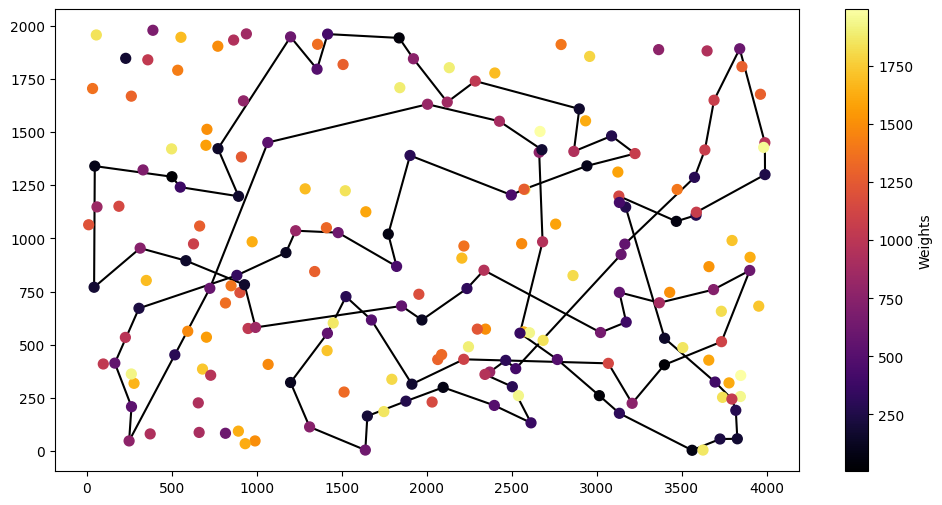

In [82]:
plot_solution(solution, coordinates, costs, '')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
scores of greedy, random, node neighborhood:  78123 85994.175 93807
[146, np.int64(181), np.int64(42), np.int64(43), np.int64(160), np.int64(34), 48, np.int64(54), 184, 116, np.int64(65), 59, np.int64(149), 35, np.int64(84), 177, 10, np.int64(190), 4, 112, np.int64(127), 123, np.int64(162), np.int64(151), 137

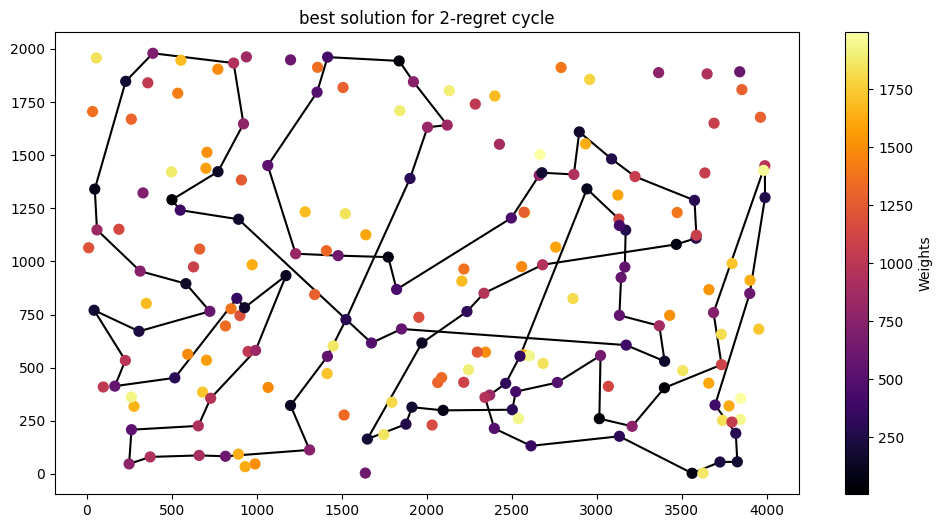

In [85]:
scores_2=[]
sols_2=[]

n = 200
neighborhood1 = NodeNeighborhood(dist, costs, n // 2)
neighborhood2 = InterNeighborhood(dist, costs, n // 2)
neighborhood = CombinedNeighborhood([neighborhood1, neighborhood2])
for x in range(200):
    print(x)
    initial_solution = get_random_solution(n)
   
    solution_2=greedy(initial_solution, dist, costs, neighborhood)
    sols_2.append(solution_2)

    scores_2.append(score(solution_2, dist, costs))   

print('scores of greedy, random, node neighborhood: ', min(scores_2), sum(scores_2)/len(scores_2), max(scores_2))
print(sols_2[scores_2.index(min(scores_2))])
plot_solution(sols_2[scores_2.index(min(scores_2))], coordinates, costs, 'best solution for 2-regret cycle')
sol_1=np.array(sols_2[scores_2.index(min(scores_2))])
pd.DataFrame(sol_1).to_csv('sol_1.csv', header=False, index=False)

In [81]:
%%timeit
greedy_2_regret_cycle2(0, dist, costs)

12.3 ms ± 70.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
%%timeit
greedy_2_regret_weighted(0, dist, costs)

12.7 ms ± 193 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
